In [10]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0,MobileNet,VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard

In [11]:
img_size = (224, 224)
batch_size = 18

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
)

train_dir = "/kaggle/input/feb-25-702010-trvaltest/3.tr70val20te10/train"
val_dir = "/kaggle/input/feb-25-702010-trvaltest/3.tr70val20te10/val"
test_dir = "/kaggle/input/feb-25-702010-trvaltest/3.tr70val20te10/test"

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 20827 images belonging to 2 classes.
Found 5952 images belonging to 2 classes.
Found 2975 images belonging to 2 classes.


In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
base_model =VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
callbacks1 = [
    ModelCheckpoint(filepath='model_weights.h5', save_best_only=True),
    EarlyStopping(patience=4,monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)]

In [18]:
os.remove('/kaggle/working/VGG19_pretrain_model.h5')

In [25]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,callbacks=[callbacks1]
)

Epoch 1/20
1158/1158 [==============================] - 476s 404ms/step - loss: 0.4171 - accuracy: 0.8078 - val_loss: 0.3582 - val_accuracy: 0.8389 - lr: 0.0010
Epoch 2/20
1158/1158 [==============================] - 324s 280ms/step - loss: 0.3312 - accuracy: 0.8560 - val_loss: 0.2877 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 3/20
1158/1158 [==============================] - 323s 279ms/step - loss: 0.3072 - accuracy: 0.8681 - val_loss: 0.2922 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 4/20
1158/1158 [==============================] - 322s 278ms/step - loss: 0.2977 - accuracy: 0.8742 - val_loss: 0.2590 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 5/20
1158/1158 [==============================] - 322s 278ms/step - loss: 0.2860 - accuracy: 0.8782 - val_loss: 0.2354 - val_accuracy: 0.9057 - lr: 0.0010
Epoch 6/20
1158/1158 [==============================] - 322s 278ms/step - loss: 0.2807 - accuracy: 0.8826 - val_loss: 0.2526 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 7/20
1158/1158 [============

In [27]:
model.save('/kaggle/working/VGG19_pretrained_weights_model.h5')

In [51]:
# Evaluate on validation data for model
val_loss, val_acc = model.evaluate(val_generator)
print('Validation loss:', val_loss)
print('Validation accuracy:', val_acc)

331/331 [==============================] - 16s 46ms/step - loss: 0.0884 - accuracy: 0.9696
Validation loss: 0.08844351768493652
Validation accuracy: 0.9695900678634644


331/331 [==============================] - 16s 47ms/step


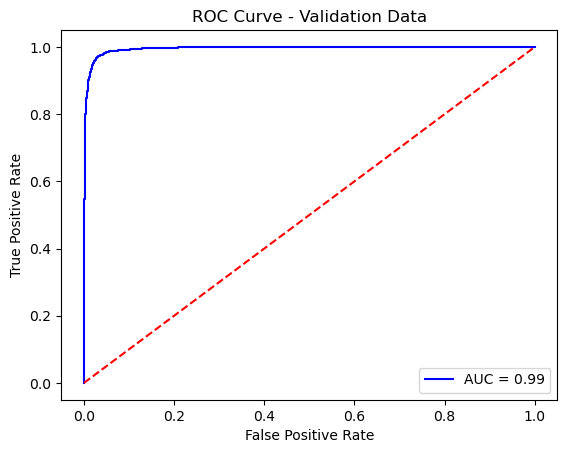

In [52]:
# Generate ROC curve for validation data
val_pred = model.predict(val_generator)
val_fpr, val_tpr, val_thresholds = roc_curve(val_generator.classes, val_pred)
val_roc_auc = auc(val_fpr, val_tpr)

plt.plot(val_fpr, val_tpr, 'b', label='AUC = %0.2f' % val_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

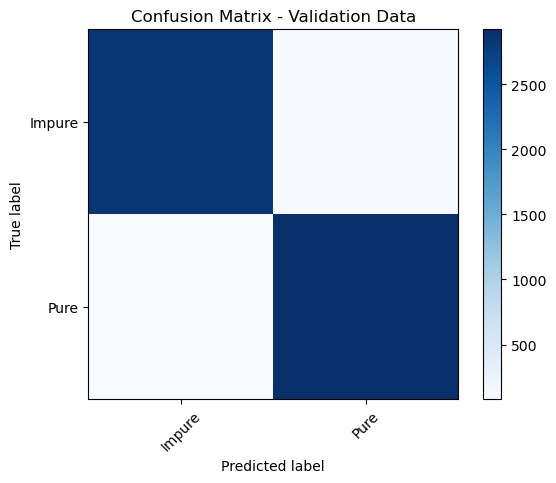

In [53]:
# Generate confusion matrix for validation data
val_pred_classes = np.round(val_pred)
val_cm = confusion_matrix(val_generator.classes, val_pred_classes)
plt.imshow(val_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Data')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Impure', 'Pure'], rotation=45)
plt.yticks(tick_marks, ['Impure', 'Pure'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [54]:
print(val_cm)

[[2851  100]
 [  81 2920]]


In [55]:
# Evaluate on test data for model
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

166/166 [==============================] - 9s 54ms/step - loss: 0.0706 - accuracy: 0.9761
Test loss: 0.07059910148382187
Test accuracy: 0.9761344790458679


166/166 [==============================] - 7s 45ms/step


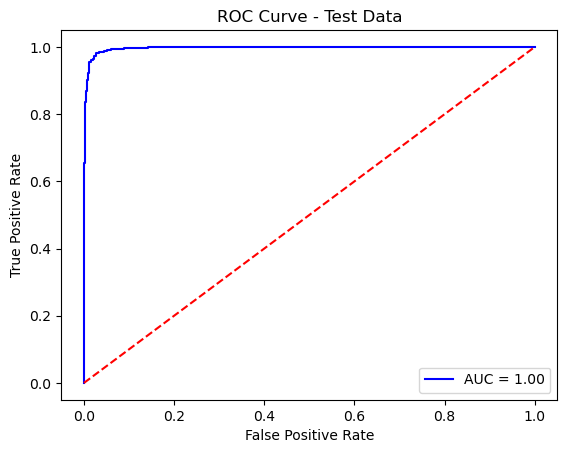

In [56]:
# Generate ROC curve for test data for model
test_pred = model.predict(test_generator)
test_fpr, test_tpr, test_thresholds = roc_curve(test_generator.classes, test_pred)
test_roc_auc = auc(test_fpr, test_tpr)

plt.plot(test_fpr, test_tpr, 'b', label='AUC = %0.2f' % test_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC Curve - Test Data')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

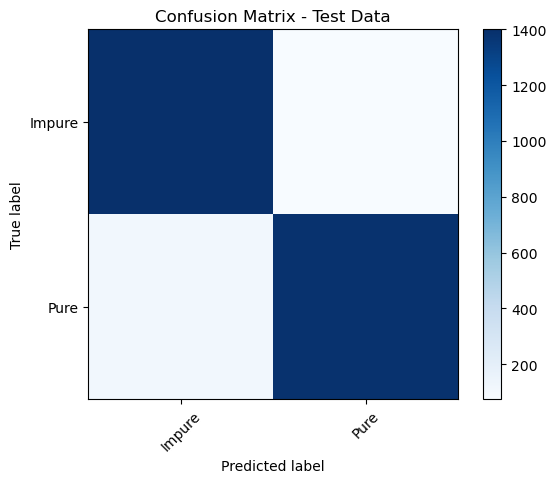

In [23]:
# Generate confusion matrix for test data
test_pred_classes = np.round(test_pred)
test_cm = confusion_matrix(test_generator.classes, test_pred_classes)
plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Impure', 'Pure'], rotation=45)
plt.yticks(tick_marks, ['Impure', 'Pure'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [24]:
print(test_cm)

[[1400   75]
 [ 113 1387]]
